## Model Exercises - Based on Walkthrough
`Corey Solitaire`   
10.30.2020   

In [2]:
import requests
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import os
from env import host, user, password
import warnings
warnings.filterwarnings("ignore")

## Wrangle:

In [17]:
# Call CSV
df = pd.read_csv('time_series_project.csv')
# Convert to Datetime
df.date = pd.to_datetime(df.date)
# Reset Index
df = df.set_index('date').sort_index()
df.head()

,calories_burned,steps,distance,floors,mins_sedentary,mins_light_active,mins_fairly_active,mins_very_active,activity_calories
date,,,,,,,,,
2018-04-26,2635.0,2931.0,1.38,2.0,1347.0,93.0,0.0,0.0,566.0
2018-04-27,3649.0,9971.0,4.70,19.0,1158.0,219.0,46.0,17.0,1752.0
2018-04-28,3379.0,3521.0,1.66,2.0,702.0,155.0,22.0,11.0,1124.0
2018-04-29,2851.0,1639.0,0.77,0.0,891.0,122.0,0.0,0.0,602.0
2018-04-30,2825.0,1323.0,0.62,0.0,880.0,104.0,0.0,0.0,540.0


In [18]:
df.shape

(247, 9)

<div class="alert alert-block alert-info"><b></b></div>

# Explore:

Split:

    1. We will use the training proprtion method to split
    2. Identify lenght of df, mult by train_prop to get the number of rows. x = train_prop * 100
    3. Select row indicies
    4. Return train and test dataframes

<div class="alert alert-block alert-info"><b></b></div>

In [19]:
train_size = int(len(df)*.5)
train_size

123

In [20]:
validate_size = int(len(df)*.3)
validate_size

74

In [21]:
test_size = int(len(df) - train_size - validate_size)
test_size

50

In [22]:
# Verify all data is accounted for
validate_end_index = train_size + validate_size
validate_end_index

197

#### Use Values to Split Data Frame

In [23]:
train = df[:train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

#### Verify Splits

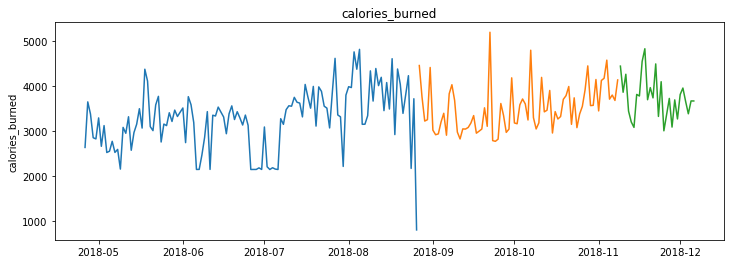

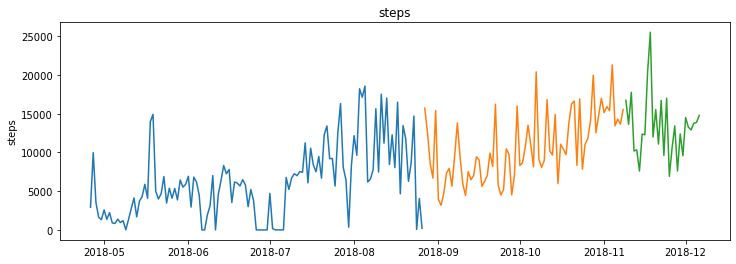

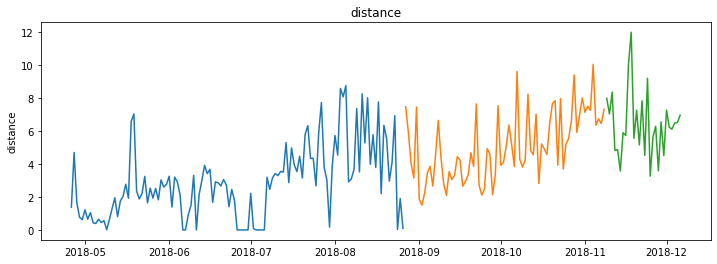

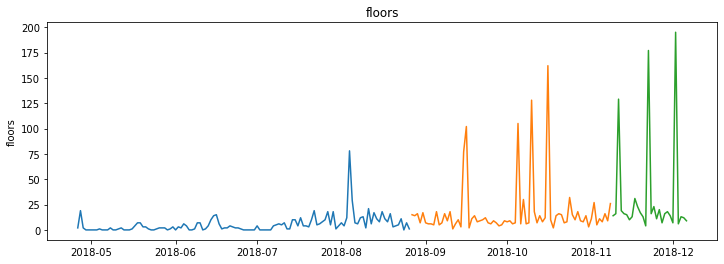

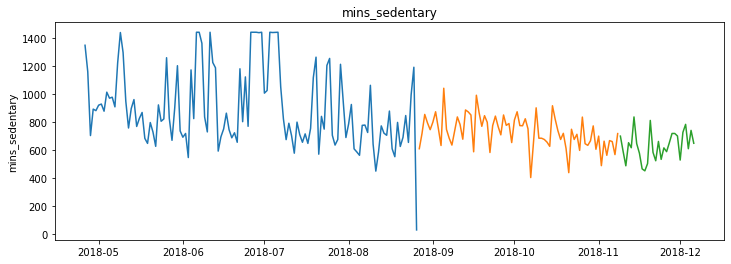

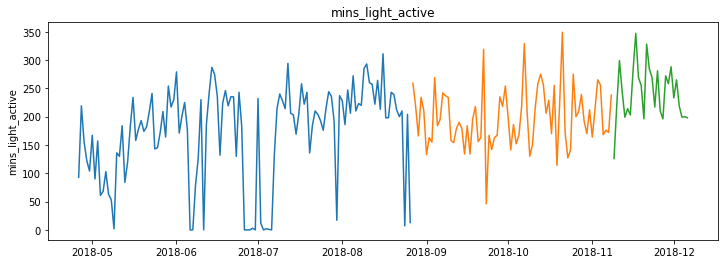

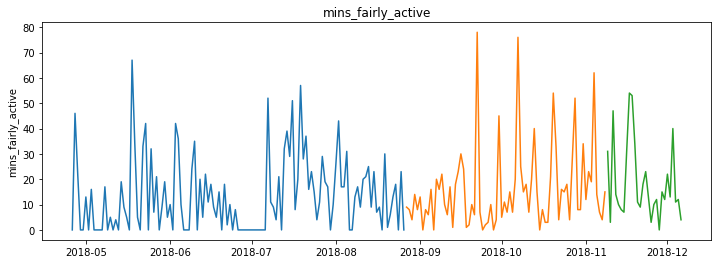

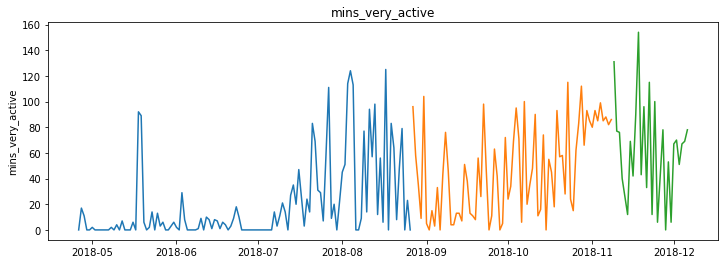

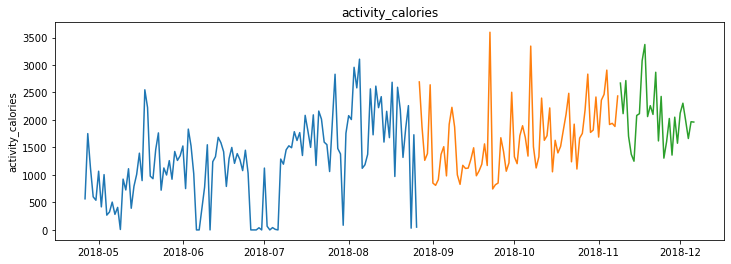

In [24]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

#### Create Evaluate Functions

In [25]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

In [26]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [27]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

In [28]:
# Verify Functions Work Properly
eval_df

,model_type,target_var,rmse


<div class="alert alert-block alert-info"><b></b></div>

# Forecast

Forecasting is another word for predicting time series data.

    Last Observed Value
    Simple Average
    Moving Average
    Holt's Linear Trend
    Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

## Last Observed Value

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions
#### Apply Predictions to Observations
#### Plot Actual Vs. Predicted Values
#### Evauate

<div class="alert alert-block alert-info"><b></b></div>

## Simple Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions
#### Apply Predictions to Observations
#### Plot Actual Vs. Predicted Values
#### Evauate

<div class="alert alert-block alert-info"><b></b></div>

## Moving Average

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions
#### Apply Predictions to Observations
#### Plot Actual Vs. Predicted Values
#### Evauate

<div class="alert alert-block alert-info"><b></b></div>

## Holt's Linear Trend

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions
#### Apply Predictions to Observations
#### Plot Actual Vs. Predicted Values
#### Evauate

<div class="alert alert-block alert-info"><b></b></div>

## Previous Cycle

<div class="alert alert-block alert-info"><b></b></div>

#### Make Predictions
#### Apply Predictions to Observations
#### Plot Actual Vs. Predicted Values
#### Evauate

<div class="alert alert-block alert-info"><b></b></div>